# Performance Benchmark: WSI Patch Extraction (Publication-ready)

This notebook benchmarks the patch extraction pipeline (`src/preprocessing/extract_patches.py`) on randomly sampled whole-slide images (WSIs).

We measure per-slide wall-clock time and relate it to slide size (level-0 pixels), mask size (non-zero ROI pixels), and the number of extracted patches. The benchmark samples 15 valid slides (reproducible seed) and saves both the raw metrics and figures under `outputs/analyse/` for reporting.


In [2]:
# Benchmarks for `src/preprocessing/extract_patches.py` - imports and configuration
import os
import time
import gc
import math
import random
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# Repo functions
from src.preprocessing.extract_patches import extract_patches
from src.preprocessing.load_wsi import load_wsi
from src.preprocessing.xml_to_mask import get_mask
from src.preprocessing.annotation_utils import resolve_annotation_path

# Configuration - adjust if needed
WSI_INDEX = 'outputs/index/wsi_index.csv'
OUT_DIR = Path('outputs/analyse')
OUT_DIR.mkdir(parents=True, exist_ok=True)
CSV_OUT = OUT_DIR / 'extract_patches_benchmark.csv'
PLOTS_DIR = OUT_DIR
N_SAMPLES = 15  # number of random slides to benchmark
PATCH_SIZE = 512
STRIDE = 512
TISSUE_THRESHOLD = 0.2
LEVEL = 0
RANDOM_SEED = 42

print(f"Benchmark config: N_SAMPLES={N_SAMPLES}, PATCH_SIZE={PATCH_SIZE}, STRIDE={STRIDE}, LEVEL={LEVEL}")


Benchmark config: N_SAMPLES=15, PATCH_SIZE=512, STRIDE=512, LEVEL=0


## Methods and design

- Sample N=15 slides uniformly at random from valid (WSI+annotation) entries in `outputs/index/wsi_index.csv` with a fixed seed for reproducibility.
- For each slide:
  - Build the ROI mask with `get_mask` and load the WSI via `load_wsi`.
  - Time `extract_patches` with `save_dir=None` (measures compute/IO without disk write).
  - Record: time_seconds, WSI dimensions (level-0), mask size (non-zero count), and number of extracted patches.
- Save a tidy CSV `outputs/analyse/extract_patches_benchmark.csv` for later graphing and a summary CSV with correlations.

Configuration below defines patch parameters, level, and sample size.


In [3]:
# Helper functions for benchmarking (modular)
import os
import time
import gc
import numpy as np

from typing import Optional, Dict, Any


def _safe_count_nonzero(mask: Optional[np.ndarray]) -> int:
    if mask is None:
        return 0
    return int(np.count_nonzero(mask))


def benchmark_slide(wsi_path: str, annotation_path: str,
                    patch_size: int = PATCH_SIZE,
                    stride: int = STRIDE,
                    tissue_threshold: float = TISSUE_THRESHOLD,
                    level: int = LEVEL) -> Optional[Dict[str, Any]]:
    """Run extract_patches for a single slide and return metrics dict.

    Returns None on fatal error.
    """
    metrics = {}
    try:
        if not (wsi_path and os.path.exists(wsi_path)):
            metrics['error'] = f'WSI missing: {wsi_path}'
            return metrics
        if not (annotation_path and os.path.exists(annotation_path)):
            metrics['error'] = f'Annotation missing: {annotation_path}'
            return metrics

        # Build mask
        mask = None
        try:
            mask = get_mask(annotation_path, wsi_path)
        except Exception as e:
            metrics['error'] = f'get_mask failed: {e}'
            return metrics

        mask_shape = mask.shape if mask is not None else (0, 0)
        mask_nonzero = _safe_count_nonzero(mask)
        mask_pixels = int(mask.size) if mask is not None else 0

        # Load WSI
        try:
            wsi = load_wsi(wsi_path)
        except Exception as e:
            metrics['error'] = f'load_wsi failed: {e}'
            return metrics

        lvl0_w, lvl0_h = wsi.level_dimensions[0]

        # Time extraction without saving to disk (pure read/processing)
        t0 = time.perf_counter()
        try:
            patches = extract_patches(
                wsi,
                mask=mask,
                size=patch_size,
                stride=stride,
                tissue_threshold=tissue_threshold,
                level=level,
                save_dir=None,
                save_prefix=os.path.splitext(os.path.basename(wsi_path))[0],
                save_format='png'
            )
        finally:
            elapsed = time.perf_counter() - t0

        num_patches = len(patches) if patches is not None else 0
        time_per_patch = elapsed / num_patches if num_patches > 0 else float('nan')

        # Approximate grid attempts for context
        width_level, height_level = wsi.level_dimensions[level]
        grid_x = max(0, (width_level - patch_size) // stride + 1)
        grid_y = max(0, (height_level - patch_size) // stride + 1)
        approx_grid_attempts = int(grid_x * grid_y)

        metrics.update({
            'wsi_path': wsi_path,
            'annotation_path': annotation_path,
            'lvl0_width': int(lvl0_w),
            'lvl0_height': int(lvl0_h),
            'wsi_pixels': int(lvl0_w) * int(lvl0_h),
            'mask_width': int(mask_shape[1]) if mask_shape else 0,
            'mask_height': int(mask_shape[0]) if mask_shape else 0,
            'mask_pixels': int(mask_pixels),
            'mask_nonzero': int(mask_nonzero),
            'mask_fraction': float(mask_nonzero) / float(mask_pixels) if mask_pixels>0 else float('nan'),
            'patch_size': int(patch_size),
            'stride': int(stride),
            'num_patches': int(num_patches),
            'approx_grid_attempts': int(approx_grid_attempts),
            'time_seconds': float(elapsed),
            'time_per_patch_s': float(time_per_patch),
            'error': None,
        })

        return metrics

    except Exception as e:
        # Catch-all to avoid notebook crash; return error in metrics
        return {'error': f'benchmark exception: {e}'}

    finally:
        try:
            if 'wsi' in locals() and hasattr(wsi, 'close'):
                wsi.close()
        except Exception:
            pass
        try:
            del mask
        except Exception:
            pass
        try:
            del patches
        except Exception:
            pass
        gc.collect()


In [4]:
# Runner cell: select N random slides and run the benchmark
import os
import random
import pandas as pd

random.seed(RANDOM_SEED)

if not os.path.exists(WSI_INDEX):
    raise FileNotFoundError(f"WSI index not found: {WSI_INDEX}")

wsi_df = pd.read_csv(WSI_INDEX)
# Filter rows with annotation_path
valid_rows = []
for _, r in wsi_df.iterrows():
    ann = r.get('annotation_path') if 'annotation_path' in r else None
    wsi = r.get('wsi_path') if 'wsi_path' in r else None
    if not ann or pd.isna(ann):
        continue
    if not wsi or pd.isna(wsi):
        continue
    if not os.path.exists(wsi):
        continue
    if not os.path.exists(ann):
        continue
    valid_rows.append(r)

if len(valid_rows) == 0:
    raise RuntimeError('No valid WSI + annotation pairs found in index')

sample_size = min(N_SAMPLES, len(valid_rows))
sample_rows = random.sample(valid_rows, sample_size)

print(f"Running benchmark on {sample_size} randomly selected slides (seed={RANDOM_SEED})")

collected = []
for idx, row in enumerate(sample_rows, start=1):
    slide_id = row.get('slide_id') if 'slide_id' in row else os.path.splitext(os.path.basename(str(row.get('wsi_path'))))[0]
    print(f"[{idx}/{sample_size}] Benchmarking: {slide_id}")
    metrics = benchmark_slide(row.get('wsi_path'), row.get('annotation_path'))
    if metrics is None:
        print(f"  Skipped {slide_id} due to error")
        continue
    metrics['slide_id'] = slide_id
    collected.append(metrics)

if collected:
    df_out = pd.DataFrame(collected)
    df_out.to_csv(CSV_OUT, index=False)
    print(f"Saved benchmark CSV to: {CSV_OUT}")
else:
    print('No benchmark results collected.')


Running benchmark on 15 randomly selected slides (seed=42)
[1/15] Benchmarking: TCGA-AO-A0JM-01Z-00-DX1
[2/15] Benchmarking: Her2Neg_Case_60
[3/15] Benchmarking: Her2Neg_Case_13
[4/15] Benchmarking: TCGA-BH-A18U-01Z-00-DX1
[5/15] Benchmarking: Her2Pos_Case_47
[6/15] Benchmarking: Her2Pos_Case_31
[7/15] Benchmarking: Her2Pos_Case_18
[8/15] Benchmarking: Her2Neg_Case_74
[9/15] Benchmarking: TCGA-BH-A18J-01Z-00-DX1
[10/15] Benchmarking: Her2Neg_Case_55
[11/15] Benchmarking: TCGA-AR-A24U-01Z-00-DX1
[12/15] Benchmarking: TCGA-A2-A0YG-01Z-00-DX1
[13/15] Benchmarking: Her2Neg_Case_47
[14/15] Benchmarking: TCGA-A8-A097-01Z-00-DX1
[15/15] Benchmarking: S14-13440
Saved benchmark CSV to: outputs/analyse/extract_patches_benchmark.csv


In [5]:
# Summary statistics and correlations (publication table)
import pandas as pd
import numpy as np
from scipy import stats

if not CSV_OUT.exists():
    print(f"CSV not found at {CSV_OUT}. Run the runner cell first.")
else:
    df = pd.read_csv(CSV_OUT)
    # Ensure numeric types
    for c in ['time_seconds', 'wsi_pixels', 'mask_nonzero', 'num_patches']:
        df[c] = pd.to_numeric(df.get(c), errors='coerce')

    # Basic summary for time per slide
    summary = {
        'n_slides': int(df.shape[0]),
        'time_seconds_mean': float(df['time_seconds'].mean(skipna=True)),
        'time_seconds_median': float(df['time_seconds'].median(skipna=True)),
        'time_seconds_std': float(df['time_seconds'].std(skipna=True)),
        'time_seconds_min': float(df['time_seconds'].min(skipna=True)),
        'time_seconds_max': float(df['time_seconds'].max(skipna=True)),
    }

    # Correlations (Pearson and Spearman) to slide size, mask size, patch count
    corr_rows = []
    for feat in ['wsi_pixels', 'mask_nonzero', 'num_patches']:
        sub = df[[feat, 'time_seconds']].dropna()
        if len(sub) >= 2:
            r_p, p_p = stats.pearsonr(sub[feat], sub['time_seconds'])
            r_s, p_s = stats.spearmanr(sub[feat], sub['time_seconds'])
            corr_rows.append({
                'feature': feat,
                'pearson_r': float(r_p), 'pearson_p': float(p_p),
                'spearman_r': float(r_s), 'spearman_p': float(p_s),
                'n': int(len(sub))
            })
        else:
            corr_rows.append({
                'feature': feat,
                'pearson_r': np.nan, 'pearson_p': np.nan,
                'spearman_r': np.nan, 'spearman_p': np.nan,
                'n': int(len(sub))
            })

    summary_df = pd.DataFrame([summary])
    corr_df = pd.DataFrame(corr_rows)

    # Save summary table
    summary_path = OUT_DIR / 'extract_patches_benchmark_summary.csv'
    with open(summary_path, 'w') as f:
        f.write('# summary\n')
    summary_df.to_csv(summary_path, mode='a', index=False)
    with open(summary_path, 'a') as f:
        f.write('\n# correlations\n')
    corr_df.to_csv(summary_path, mode='a', index=False)

    display(summary_df)
    display(corr_df)
    print(f"Saved summary to: {summary_path}")


,n_slides,time_seconds_mean,time_seconds_median,time_seconds_std,time_seconds_min,time_seconds_max
0,15,12.477498,3.097661,17.50011,0.3559,61.256872


,feature,pearson_r,pearson_p,spearman_r,spearman_p,n
0,wsi_pixels,0.856417,4.586426e-05,0.928571,5.867938e-07,15
1,mask_nonzero,0.992754,2.380287e-13,0.989286,2.998934e-12,15
2,num_patches,0.993320,1.404213e-13,0.995532,1.033593e-14,15


Saved summary to: outputs/analyse/extract_patches_benchmark_summary.csv


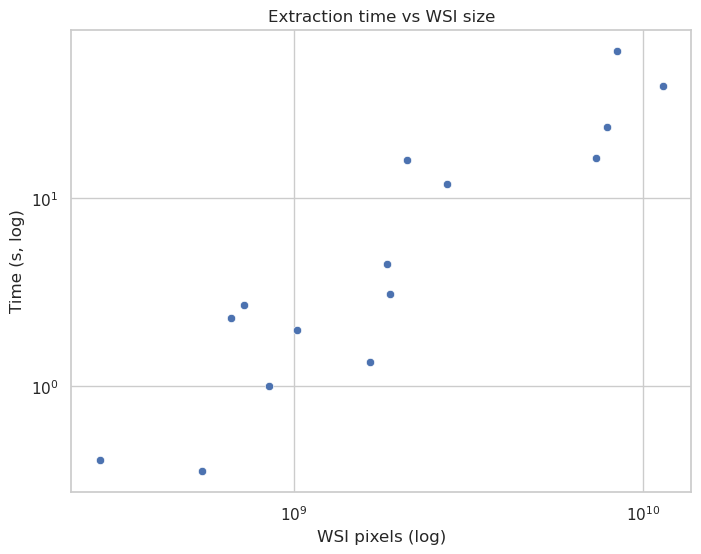

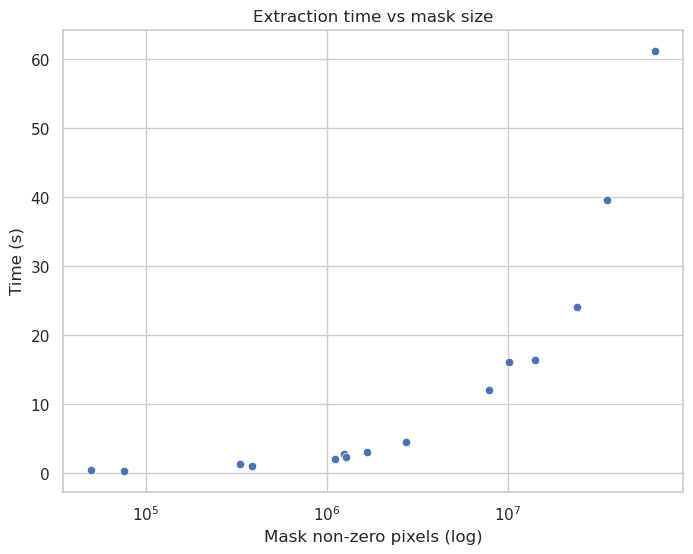

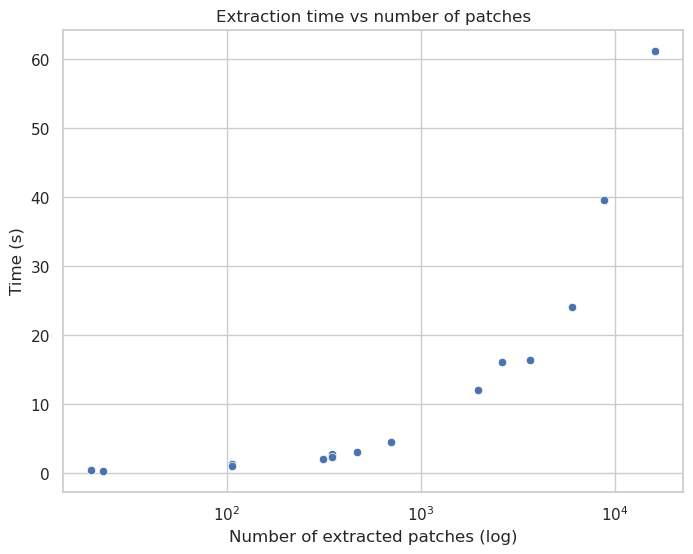

Correlation(time_seconds, wsi_pixels) = 0.856
Correlation(time_seconds, mask_nonzero) = 0.993
Correlation(time_seconds, num_patches) = 0.993
Saved plots to outputs/analyse


In [6]:
# Plotting and visualization cell
# Reads the CSV produced by the runner and creates plots saved to disk and displayed inline.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

if not CSV_OUT.exists():
    print(f"CSV not found at {CSV_OUT}. Run the runner cell first.")
else:
    df = pd.read_csv(CSV_OUT)
    # Basic cleaning / type conversions
    df['time_seconds'] = pd.to_numeric(df['time_seconds'], errors='coerce')
    df['wsi_pixels'] = pd.to_numeric(df['wsi_pixels'], errors='coerce')
    df['mask_nonzero'] = pd.to_numeric(df['mask_nonzero'], errors='coerce')
    df['num_patches'] = pd.to_numeric(df['num_patches'], errors='coerce')

    # Scatter: time vs WSI pixels (log-log)
    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(x='wsi_pixels', y='time_seconds', data=df, ax=ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('WSI pixels (log)')
    ax.set_ylabel('Time (s, log)')
    ax.set_title('Extraction time vs WSI size')
    out1 = PLOTS_DIR / 'time_vs_wsi_pixels.png'
    fig.savefig(out1, dpi=150, bbox_inches='tight')
    plt.show()

    # Scatter: time vs mask_nonzero
    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(x='mask_nonzero', y='time_seconds', data=df, ax=ax)
    ax.set_xscale('log')
    ax.set_xlabel('Mask non-zero pixels (log)')
    ax.set_ylabel('Time (s)')
    ax.set_title('Extraction time vs mask size')
    out2 = PLOTS_DIR / 'time_vs_mask_nonzero.png'
    fig.savefig(out2, dpi=150, bbox_inches='tight')
    plt.show()

    # Scatter: time vs num_patches
    fig, ax = plt.subplots(figsize=(8,6))
    sns.scatterplot(x='num_patches', y='time_seconds', data=df, ax=ax)
    ax.set_xscale('log')
    ax.set_xlabel('Number of extracted patches (log)')
    ax.set_ylabel('Time (s)')
    ax.set_title('Extraction time vs number of patches')
    out3 = PLOTS_DIR / 'time_vs_num_patches.png'
    fig.savefig(out3, dpi=150, bbox_inches='tight')
    plt.show()

    # Print simple correlations
    for c in ['wsi_pixels', 'mask_nonzero', 'num_patches']:
        valid = df[[c, 'time_seconds']].dropna()
        if len(valid) > 1:
            corr = valid[c].corr(valid['time_seconds'])
            print(f"Correlation(time_seconds, {c}) = {corr:.3f}")
        else:
            print(f"Not enough data to compute correlation for {c}")

    print(f"Saved plots to {PLOTS_DIR}")


## Reproducibility and usage

- Configure parameters in Cell 2 (imports & configuration). Default: `N_SAMPLES = 15`, `PATCH_SIZE = 512`, `STRIDE = 512`, `LEVEL = 0`, `RANDOM_SEED = 42`.
- Run cells in order:
  1) Title (informational)
  2) Imports & configuration
  3) Methods (informational)
  4) Helper functions
  5) Runner (executes sampling and benchmarking; writes CSV)
  6) Summary statistics (saves `extract_patches_benchmark_summary.csv`)
  7) Plotting (saves three PNGs)

Artifacts (for publication):
- Raw metrics CSV: `outputs/analyse/extract_patches_benchmark.csv`
- Summary + correlations CSV: `outputs/analyse/extract_patches_benchmark_summary.csv`
- Figures: `time_vs_wsi_pixels.png`, `time_vs_mask_nonzero.png`, `time_vs_num_patches.png` in `outputs/analyse/`

Environment notes:
- Requires WSI IO dependencies (e.g., OpenSlide/cuCIM) compatible with your data and `load_wsi` implementation.
- Random sampling is reproducible via `RANDOM_SEED`.
